In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import sklearn.cluster as cluster
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram


LKB = pd.read_excel (r'DataDRtechniques.xlsx',
                    sheet_name='LKBPP screen dataset')

descriptors = ['homo', 'lumo', 'pa', 'homo2', 'lumo2', 'pa2', 'he.w.pn', 'nhe', 'be.gla', 'ml.gla', 'dmd.gla', 'd.d1rgla', 'd.d2rgla', 'drd1rgla', 
               'drd2rgla', 'nbo.glaf', 'be.pd', 'ml.pd', 'dmd.pd', 'd.d1r.pd', 'd.d2r.pd', 'd.rd1rpd', 'd.rd2rpd', 'nbo.pd.f', 'dppd.d1', 'dppd.d2', 
               'dpzn.d1', 'dpzn.d2']

In [2]:
# Scale the data
scaler = StandardScaler()
data_std = scaler.fit_transform(LKB[descriptors])

In [3]:
#Definition of each dimensionality reduction technique (it take a while to run because of tsne)
pca = PCA(n_components=7).fit_transform(data_std)
pca_df_scale = pd.DataFrame(pca, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7'])

tsne = TSNE(n_components=10, verbose=0, perplexity=12, n_iter=5000, learning_rate="auto", method='exact', random_state=42).fit_transform(data_std)
tsne_df_scale = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3','tsne4', 'tsne5', 'tsne6', 'tsne7', 'tsne8', 'tsne9', 'tsne10'])

umap_5 = umap.UMAP(n_neighbors=5,min_dist=0.5,n_components=10,random_state=42).fit_transform(data_std)
umap_df_scale_5 = pd.DataFrame(umap_5, columns=['umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 'umap8', 'umap9', 'umap10'])

umap_10 = umap.UMAP(n_neighbors=10,min_dist=0.5,n_components=10,random_state=42).fit_transform(data_std)
umap_df_scale_10 = pd.DataFrame(umap_10, columns=['umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 'umap8', 'umap9', 'umap10'])

umap_15 = umap.UMAP(n_neighbors=15,min_dist=0.5,n_components=10,random_state=42).fit_transform(data_std)
umap_df_scale_15 = pd.DataFrame(umap_15, columns=['umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 'umap8', 'umap9', 'umap10'])

In [24]:
#Choose one DR technique: 
#DR=pca/umap/tsne
#DR_df_scale=pca_df_scale/umap_df_scale/tsne_df_scale 

#for umap select the option depending on the number of neighbours (5,10 or 15)

DR=umap_10
DR_df_scale=umap_df_scale_10

#Set the k you want to use (if you want to use the optimal k and n go the optimal cluster notebook)
#Choose k for k means and n for hierarchical
k=6
n=6

In [25]:
#Definition of k means clustering for the selected DR:
def kmeans(k,DR_df_scale):
    """input: k = the number of clusters
              Dr_df_scale = the selected DR technique
       the function: performs k means and provide the silhouette coefficient for the selected DR technique
       output: silhouette coefficient"""
    kmeans_DR_scale = KMeans(n_clusters=k, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(DR_df_scale)
    print('KMeans DR choosen Scaled Silhouette Score: {}'.format(silhouette_score(DR_df_scale, kmeans_DR_scale.labels_, metric='euclidean')))
    kmeans_labels = kmeans_DR_scale.labels_
    clusters_DR_scale = pd.concat([DR_df_scale, pd.DataFrame({'DR_clusters':kmeans_labels})], axis=1)
    return kmeans_labels

In [26]:
#Definition of hierarchical clustering for the selected DR: 
def hierarchical(n,DR_df_scale):
    cluster_hie = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster_hie.fit_predict(DR_df_scale)
    hierarchical_labels=cluster_hie.labels_
    print('Hierarchical DR choosen Scaled Silhouette Score: {}'.format(silhouette_score(DR_df_scale, cluster_hie.labels_, metric='euclidean')))
    hierarchical_labels=cluster_hie.labels_
    return hierarchical_labels

In [27]:
kmeans_labels=kmeans(k,DR_df_scale)
hierarchical_labels=hierarchical(n,DR_df_scale)

style=False
hue=kmeans_labels
#hue=LKB['be.pd'] 
palette='Spectral'
title='UMAP coloured by be.pd descriptor'

C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans DR choosen Scaled Silhouette Score: 0.4356376528739929
Hierarchical DR choosen Scaled Silhouette Score: 0.38488125801086426


C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
#Important, for the case of PCA the components were multiplied by -1, to be consistent with the software (SIMCA) that was used before- 
def plots(DR,hue,
          style,
          palette,title):
    """input: DR = dimensionality redution technique you want to use (by default it will give 1st and 2nd component)
              hue = the feature of the LKB you want to be colored by, LKB['feature']
              IMPORTANT NOTE: for kmeans use kmeans_labels, for hierarchical use hierarchical_labels
              style = Used if you want to compare a feature of the LKB with a clustering technique 
              palette = Type of palette used, 'palette'
              title = Set the title you want 'Title'
       the funtion: It will take as data the DR technique selected, by default it will take the first two components (this can be changed manually),
                    a plot will be returned according to the input settings. 
       output: give the plot according to the information requested in the input"""
    
    plt.figure(figsize = (7,5))
    sns.scatterplot(data=DR,
 #If you are using PCA and you want the same plot as in the BT multiply each component by -1, for the rest of techniques it is fine. 
        x=1*DR[:,0],
        y=1*DR[:,1],
        hue=hue,
        style=style,
        palette=palette, 
        s=50, 
        alpha=1).set_title(title, fontsize=15)
    
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend()
    plt.show()

    return 


In [34]:
def plots3D(DR,hue):
    x=DR[:,0]
    y=DR[:,1]
    z=DR[:,2]

    ax = plt.axes(projection='3d')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.scatter(x, y, z, cmap='Set2', linewidth=0.5, c=hue)

    ax.text2D(0.05, 0.95, "3D representation of the choosen DR colored by the desired feature",fontsize=20, transform=ax.transAxes)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')

    plt.show()
    return 

In [35]:
kmeans(k,DR_df_scale)

C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans DR choosen Scaled Silhouette Score: 0.4356376528739929


array([4, 0, 4, 4, 1, 4, 0, 2, 0, 0, 5, 4, 0, 4, 4, 1, 4, 0, 2, 0, 0, 5,
       4, 3, 4, 4, 1, 4, 0, 2, 0, 0, 5, 4, 3, 4, 4, 1, 4, 0, 2, 0, 0, 5,
       0, 0, 4, 4, 1, 0, 0, 2, 0, 0, 5, 4, 0, 4, 4, 1, 4, 0, 2, 0, 0, 0,
       4, 3, 4, 4, 1, 0, 0, 2, 0, 0, 5, 4, 3, 4, 4, 1, 4, 0, 2, 0, 0, 5,
       4, 3, 4, 4, 1, 4, 0, 5, 0, 0, 5, 0, 0, 4, 4, 1, 0, 0, 2, 0, 0, 5,
       0, 3, 4, 4, 1, 0, 0, 5, 0, 0, 5, 4, 3, 4, 4, 1, 4, 0, 5, 0, 0, 5,
       0, 3, 4, 4, 1, 0, 0, 5, 0, 0, 5, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 0, 4, 4, 1, 0, 0, 2, 0, 0, 5,
       0, 3, 4, 4, 1, 0, 0, 5, 0, 0, 5, 0, 3, 4, 4, 1, 0, 0, 5, 3, 0, 5,
       0, 3, 4, 4, 1, 3, 0, 5, 3, 3, 3, 0, 3, 4, 4, 1, 3, 3, 5, 3, 3, 5,
       0, 0, 4, 4, 1, 4, 0, 5, 0, 0, 0, 0, 3, 4, 4, 1, 3, 3, 5, 3, 3, 5,
       0, 3, 4, 4, 1, 0, 3, 3, 3, 3, 3, 0, 3, 4, 4, 1, 0, 0, 2, 0, 0, 5,
       0, 3, 4, 4, 1, 4, 0, 5, 3, 0, 5])

In [36]:
hierarchical(n,DR_df_scale)

Hierarchical DR choosen Scaled Silhouette Score: 0.38488125801086426


C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([4, 4, 4, 2, 3, 4, 1, 5, 1, 1, 0, 4, 4, 4, 2, 3, 4, 1, 5, 1, 1, 0,
       4, 0, 4, 2, 3, 4, 1, 5, 1, 1, 0, 4, 0, 4, 2, 3, 4, 0, 5, 1, 0, 0,
       1, 0, 4, 2, 3, 1, 1, 5, 1, 1, 0, 4, 4, 4, 2, 3, 4, 1, 5, 1, 1, 1,
       4, 0, 4, 2, 3, 4, 0, 5, 1, 0, 0, 4, 0, 4, 2, 3, 4, 1, 5, 1, 1, 0,
       4, 0, 4, 2, 3, 4, 1, 0, 1, 1, 0, 1, 0, 4, 2, 3, 1, 1, 5, 1, 1, 0,
       1, 0, 4, 2, 3, 4, 0, 0, 1, 0, 0, 4, 0, 4, 2, 3, 4, 1, 0, 1, 1, 0,
       1, 0, 4, 2, 3, 4, 1, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 3, 1, 1, 5, 1, 1, 0,
       1, 0, 4, 2, 3, 1, 1, 0, 0, 1, 0, 1, 0, 4, 2, 3, 1, 0, 0, 1, 0, 0,
       1, 0, 4, 2, 3, 0, 1, 0, 1, 0, 0, 1, 0, 4, 2, 3, 0, 0, 0, 0, 0, 0,
       1, 1, 4, 2, 3, 4, 1, 0, 1, 1, 1, 1, 0, 4, 2, 3, 0, 0, 0, 0, 0, 0,
       1, 0, 4, 2, 3, 1, 0, 0, 0, 0, 0, 1, 0, 4, 2, 3, 0, 0, 5, 1, 0, 0,
       1, 0, 4, 2, 3, 4, 1, 0, 0, 1, 0], dtype=int64)

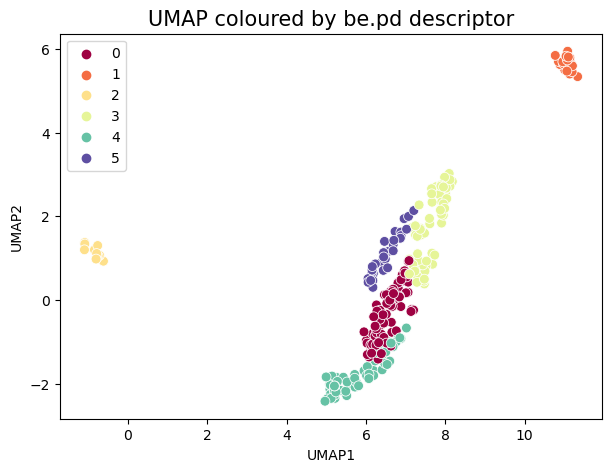

In [37]:
plots(DR,hue,
      style,
      palette,title)

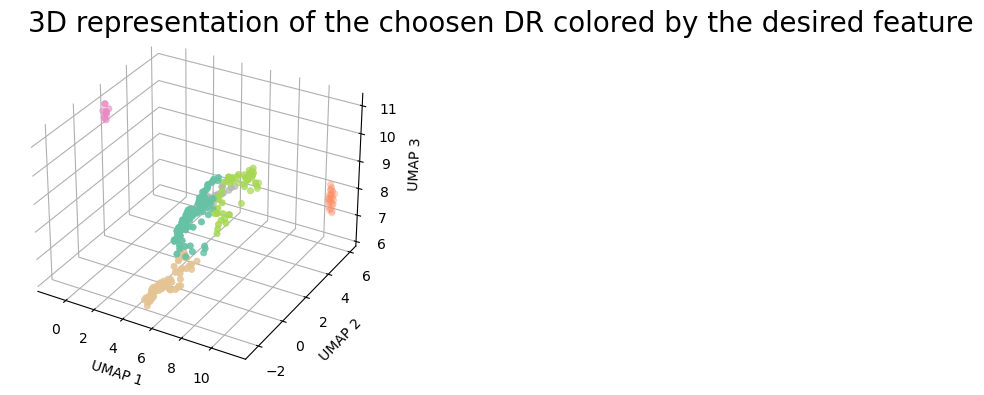

In [38]:
plots3D(DR,hue)

Other useful tools

In [14]:
#This is used to obtain the id of each cluster, for the cluster analysis (You have to change the cluster.labels_ depending on the name of each clustering method)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = LKB['No.'].index.values
cluster_map['cluster'] = kmeans_labels
pd.set_option('display.max_rows', None)
cluster_map[cluster_map.cluster == 1]

,data_index,cluster
23,23,1
34,34,1
67,67,1
78,78,1
89,89,1
111,111,1
122,122,1
133,133,1
143,143,1
144,144,1


Text(0.5, 1.0, 'PCA biplot coloured by hierarchical clustering algorithm')

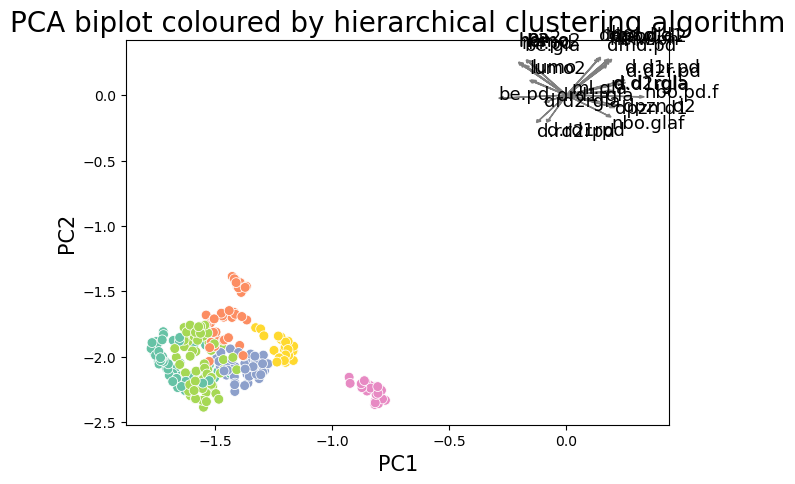

In [15]:
#Construction of a biplot (only work for PCA)
n_components = 7

std_pca = PCA(n_components=n_components)
std_pca_results = std_pca.fit_transform(data_std)

ldngs = std_pca.components_

x=1*DR[:,0]
y=1*DR[:,1]
scalePC1 = 1.0/(x.max() - x.min())
scalePC2 = 1.0/(y.max() - y.min())

fig = plt.figure(figsize=(7,5))
 
for i, feature in enumerate(descriptors):
    plt.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i], 
             head_width=0.02, 
             head_length=0.02,
             length_includes_head=0.01, 
              color="grey")
    plt.text(ldngs[0, i] * 1, 
            ldngs[1, i] * 1.5, 
            feature, fontsize=13)
 
sns.scatterplot(x=-1*DR[:,0] * scalePC1, y=-1*DR[:,1] * scalePC2, 
                hue=hierarchical_labels,
                palette='Set2',
                legend=False,
                s=50,)
 
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('PCA biplot coloured by hierarchical clustering algorithm', fontsize=20)

In [16]:
#Obtaining the explaied variance numerically (only work for PCA)
std_variance = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(std_pca.explained_variance_ratio_ * 100)
}
print(std_variance)

{'0': 'PC 1 (29.5%)', '1': 'PC 2 (26.2%)', '2': 'PC 3 (9.6%)', '3': 'PC 4 (8.4%)', '4': 'PC 5 (5.9%)', '5': 'PC 6 (5.3%)', '6': 'PC 7 (3.1%)'}


C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\envs\rdkit\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can a

Text(0, 0.5, 'Inertia')

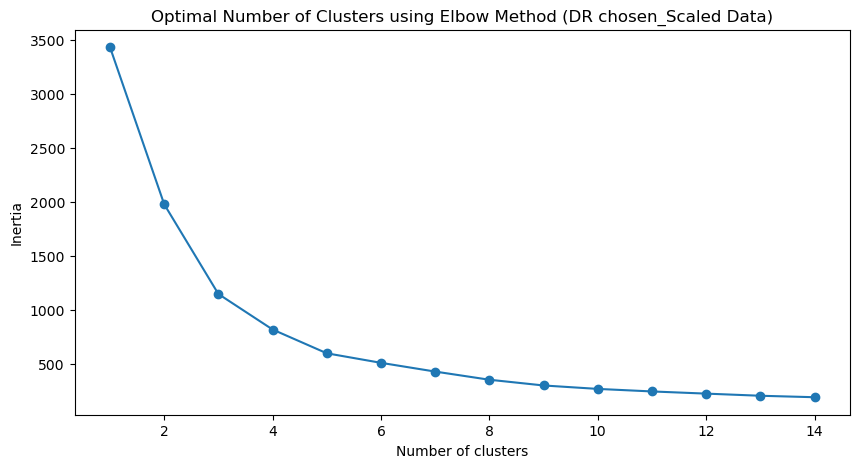

In [17]:
#Definition of the optimal k for kmeans (correspond to the inflexion point on the graph)
sse = []

#Set a list of possible k for kmeans 
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(DR_df_scale)
    sse.append([k, km.inertia_])
    
plt.figure(figsize=(10,5))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (DR chosen_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

<Figure size 1000x500 with 0 Axes>

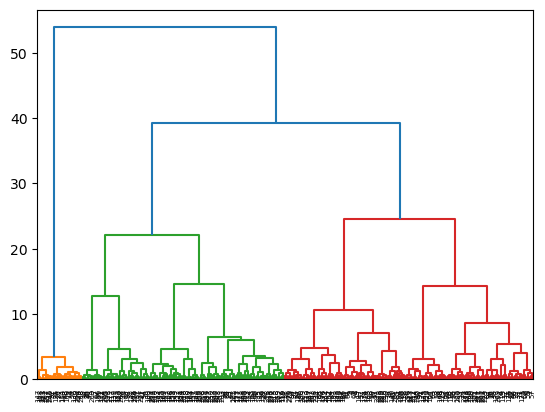

<Figure size 1000x500 with 0 Axes>

In [18]:
#Optimal n for hierarchical clustering (correspond to the number of coloured clusters)
linkage_data = linkage(DR_df_scale, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.figure(figsize=(10, 5))  